In [4]:
import pandas as pd
import utils

TS = 48

In [76]:
import numpy as np
    
def ctl_ss_sc(df, c, cmin=0.10, cmax=0.95, cinit=0.10):
    soc_sts = c*cinit
    soc_max = c*cmax
    soc_min = c*cmin
    grid = np.zeros(df.shape[0])
        
    for i, (p, l) in enumerate(zip(df['GG'].values, df['GC'].values)):
        if p > l: # charging
            charge = min(soc_max - soc_sts, p - l)
            grid[i] = -(p - l - charge)
        else: # discharging
            charge = -min(soc_sts - soc_min, l - p)
            grid[i] = l - p + charge
        soc_sts += charge
        
    df['GD'] = grid.tolist()

    return df

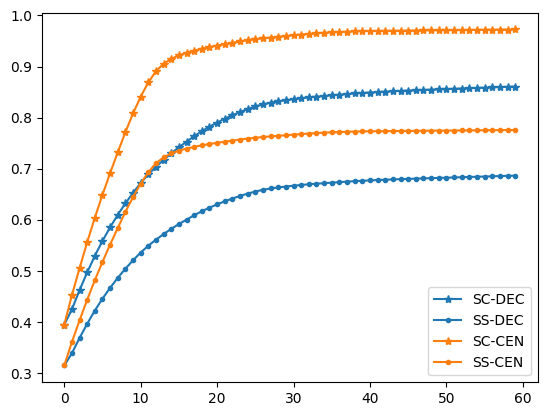

In [94]:
import pandas as pd
import utils
import matplotlib.pyplot as plt

samples = [25, 93, 1, 75]
# samples = [25, 1]

df_sel, df_date = utils.load_data('AusGrid_preprocess.csv', samples, TS)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

num_bess = 60
sc_ss = np.zeros(shape=(num_bess, 3))
for i, c in enumerate(range(num_bess)):
    df_con = pd.DataFrame(index=df_date)
    for df in df_sel:
        df_out = ctl_ss_sc(df, c)
        df_con = df_out.add(df_con, fill_value=0)

    exp = df_con['GD'].where(df_con['GD'] < 0).sum()
    imp = df_con['GD'].where(df_con['GD'] > 0).sum()

    sc = 1 + exp/df_con['GG'].sum()
    ss = 1 - imp/df_con['GC'].sum()
    sc_ss[i] = [c, sc, ss]

plt.plot(sc_ss[:, 0], sc_ss[:, 1], color=colors[0], marker='*', label='SC-DEC')
plt.plot(sc_ss[:, 0], sc_ss[:, 2], color=colors[0], marker='.', label='SS-DEC')

sc_ss = np.zeros(shape=(num_bess, 3))
for i, c in enumerate(range(num_bess)):
    df_out = pd.DataFrame(index=df_date)
    for df in df_sel:
        df_out = df.add(df_out, fill_value=0)
        
    df_con = ctl_ss_sc(df_out, c*len(df_sel))

    exp = df_con['GD'].where(df_con['GD'] < 0).sum()
    imp = df_con['GD'].where(df_con['GD'] > 0).sum()

    sc = 1 + exp/df_con['GG'].sum()
    ss = 1 - imp/df_con['GC'].sum()
    sc_ss[i] = [c, sc, ss]

plt.plot(sc_ss[:, 0], sc_ss[:, 1], color=colors[1], marker='*', label='SC-CEN')
plt.plot(sc_ss[:, 0], sc_ss[:, 2], color=colors[1], marker='.', label='SS-CEN')
plt.legend()

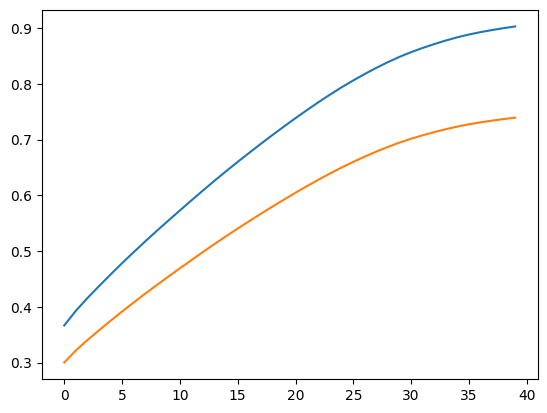